# Recommender System Based on Milennial Preferences in the Real Estate Sector in Mexico's Capital

## This notebook will be divided in four parts:
## 1. Data Wrangling
## 2. Recommender System

## 3. Visualizing results 

## 4. Clustering, just to see how each main category clusters distribution looks like

## __Part 1: Data Wrangling__

In [1]:
import pandas as pd
import numpy as np

from math import sqrt


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import requests

from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler 
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.pyplot as plt 


from shapely.geometry import Point, Polygon
import json

%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


In [14]:
col = pd.read_csv('coloniascdmx.csv')
col.head()

,COLONIA,ENTIDAD,Geo Point,Geo Shape,CVE_ALC,ALCALDIA,CVE_COL,SECC_COM,SECC_PAR
0,LOMAS DE CHAPULTEPEC,9.0,"19.4228411174,-99.2157935754","{""type"": ""Polygon"", ""coordinates"": [[[-99.2201...",16,MIGUEL HIDALGO,16-042,"4924, 4931, 4932, 4935, 4936, 4940, 4987","4923, 4937, 4938, 4939, 4942"
1,LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC),9.0,"19.4106158914,-99.2262487268","{""type"": ""Polygon"", ""coordinates"": [[[-99.2296...",16,MIGUEL HIDALGO,16-044,4963,4964
2,DEL BOSQUE (POLANCO),9.0,"19.4342189235,-99.2094037513","{""type"": ""Polygon"", ""coordinates"": [[[-99.2082...",16,MIGUEL HIDALGO,16-026,NaN,"4918, 4919"
3,PEDREGAL DE SANTA URSULA I,9.0,"19.314862237,-99.1477954505","{""type"": ""Polygon"", ""coordinates"": [[[-99.1458...",3,COYOACAN,03-135,"433, 500, 431, 513, 501","424, 425, 426, 430, 499"
4,AJUSCO I,9.0,"19.324571116,-99.1561602234","{""type"": ""Polygon"", ""coordinates"": [[[-99.1585...",3,COYOACAN,03-128,"376, 377, 378, 379, 404, 493, 498",374


In [15]:
col.drop(columns = ['ENTIDAD','CVE_COL', 'SECC_COM', 'SECC_PAR', 'CVE_ALC', 'Geo Shape'], inplace = True)
col.head()

,COLONIA,Geo Point,ALCALDIA
0,LOMAS DE CHAPULTEPEC,"19.4228411174,-99.2157935754",MIGUEL HIDALGO
1,LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC),"19.4106158914,-99.2262487268",MIGUEL HIDALGO
2,DEL BOSQUE (POLANCO),"19.4342189235,-99.2094037513",MIGUEL HIDALGO
3,PEDREGAL DE SANTA URSULA I,"19.314862237,-99.1477954505",COYOACAN
4,AJUSCO I,"19.324571116,-99.1561602234",COYOACAN


In [16]:
dfcol = col.groupby(['ALCALDIA', 'Geo Point']).agg(lambda x: ','.join(x)).reset_index(drop = False)
#dfcol =dfcol.loc[dfcol['ALCALDIA'].isin(['COYOACAN','MIGUEL HIDALGO','TLALPAN', 'ALVARO OBREGON', 'BENITO JUAREZ'])].reset_index(drop=True)
dfcol =dfcol.loc[dfcol['ALCALDIA'].isin(['COYOACAN', 'ALVARO OBREGON', 'BENITO JUAREZ'])].reset_index(drop=True)
#dfcol = col.groupby(['ALCALDIA']).agg(lambda x: ','.join(x)).reset_index(drop = False)
dfcol

,ALCALDIA,Geo Point,COLONIA
0,ALVARO OBREGON,"19.3104750424,-99.2717178529",LOMAS DE CAPULIN
1,ALVARO OBREGON,"19.3153569742,-99.2732448612",PARAJE EL CABALLITO
2,ALVARO OBREGON,"19.3170165912,-99.268434575",LOMAS DE CHAMONTOYA
3,ALVARO OBREGON,"19.3197415813,-99.2074193222",JARDINES DEL PEDREGAL
4,ALVARO OBREGON,"19.3211369234,-99.2626670718",LOMAS DE LA ERA
...,...,...,...
461,COYOACAN,"19.3512447243,-99.1403710755",COUNTRY CLUB
462,COYOACAN,"19.3519012702,-99.1482796852",SAN MATEO (BARR)
463,COYOACAN,"19.3541145678,-99.163808041",DEL CARMEN
464,COYOACAN,"19.3545178048,-99.1268016586",PRADO CHURUBUSCO


In [78]:
dfcol.dtypes

ALCALDIA     object
Geo Point    object
COLONIA      object
dtype: object

In [17]:
dfcol[['lat','long']] = dfcol['Geo Point'].str.split(',', expand=True).astype(float)
dfcol.drop(columns=['Geo Point'])
#dfcol[['lat','long']].astype(float)
dfcol.head()
#dfcol['Geo Point'].str.split(',', expand=True)
#dfcol.head()

,ALCALDIA,Geo Point,COLONIA,lat,long
0,ALVARO OBREGON,"19.3104750424,-99.2717178529",LOMAS DE CAPULIN,19.310475,-99.271718
1,ALVARO OBREGON,"19.3153569742,-99.2732448612",PARAJE EL CABALLITO,19.315357,-99.273245
2,ALVARO OBREGON,"19.3170165912,-99.268434575",LOMAS DE CHAMONTOYA,19.317017,-99.268435
3,ALVARO OBREGON,"19.3197415813,-99.2074193222",JARDINES DEL PEDREGAL,19.319742,-99.207419
4,ALVARO OBREGON,"19.3211369234,-99.2626670718",LOMAS DE LA ERA,19.321137,-99.262667


In [80]:
dfcol.shape

(466, 5)

In [81]:
latitude = 19.4284700 
longitude= -99.1276600
# create map of New York using latitude and longitude values
map_cdmx = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='cartodbdark_matter')

# add markers to map
for lat, lng, borough, neighborhood in zip(dfcol['lat'], dfcol['long'], dfcol['ALCALDIA'], dfcol['COLONIA']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cdmx)  
    
map_cdmx

In [84]:
# That a shitload of neighborhoods.
dfcol.head()

,ALCALDIA,Geo Point,COLONIA,lat,long
0,ALVARO OBREGON,"19.3104750424,-99.2717178529",LOMAS DE CAPULIN,19.310475,-99.271718
1,ALVARO OBREGON,"19.3153569742,-99.2732448612",PARAJE EL CABALLITO,19.315357,-99.273245
2,ALVARO OBREGON,"19.3170165912,-99.268434575",LOMAS DE CHAMONTOYA,19.317017,-99.268435
3,ALVARO OBREGON,"19.3197415813,-99.2074193222",JARDINES DEL PEDREGAL,19.319742,-99.207419
4,ALVARO OBREGON,"19.3211369234,-99.2626670718",LOMAS DE LA ERA,19.321137,-99.262667


In [82]:
#Setting up credential for foursquare
CLIENT_ID = 'My_Client_ID' # your Foursquare ID
CLIENT_SECRET = 'My_Client_Secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [83]:
def getNearbyVenues(names, latitudes, longitudes, radius=400):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [63]:
getting nearby venue of each CDMX neigh:
LIMIT = 100
cdmx_venues = getNearbyVenues(names=dfcol['COLONIA'],
                                   latitudes=dfcol['lat'],
                                   longitudes=dfcol['long']
                                  )

In [45]:

print(cdmx_venues.shape)
cdmx_venues = cdmx_venues[['neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude', 'Venue Longitude', 'Venue Category']]
cdmx_venues.head()

(9323, 343)


,neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,LOMAS DE CHAMONTOYA,19.317017,-99.268435,Las Nalgas de Rasputia Bar,19.316464,-99.269244,Speakeasy
1,LOMAS DE CHAMONTOYA,19.317017,-99.268435,Soluciones Bionotariales,19.318539,-99.267452,Speakeasy
2,LOMAS DE CHAMONTOYA,19.317017,-99.268435,don pancho,19.314666,-99.269369,Candy Store
3,LOMAS DE CHAMONTOYA,19.317017,-99.268435,abartotes carolina,19.315986,-99.265997,Grocery Store
4,LOMAS DE CHAMONTOYA,19.317017,-99.268435,Hamburguesas capulin,19.314062,-99.266942,Burger Joint


In [ ]:
cdmx_venues['Venue Category'].describe(include=['object'])

In [100]:
cdmx_venues.to_csv('cdmx_venues.csv', encoding='utf-8', index=False)
#These are checkpoints I use in order to not all the notebook every time I turn off my computer.

## Since subway stations are not included with accuracy in this dataset, they must be manually included. This is done with the col and cdf dataframes

In [74]:
cdmx_venues = pd.read_csv('cdmx_venues.csv')
cdmx_venues =cdmx_venues.rename(columns={"Neighborhood":"neighborhood"})
#cd[cdmx_venues['Venue Category'].unique()] =  [cdmx_venues['Venue Category'].()]



In [75]:
b = cdmx_venues.groupby(['neighborhood']).count()
b.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
neighborhood,,,,,,
19 DE MAYO,6,6,6,6,6,6
1RA VICTORIA,33,33,33,33,33,33
1RA VICTORIA SECCION BOSQUES,10,10,10,10,10,10
26 DE JULIO,4,4,4,4,4,4
2DA JALALPA TEPITO (AMPL),6,6,6,6,6,6


In [76]:
cd = cdmx_venues
for i in cdmx_venues['Venue Category'].unique():
    cd[i]= 0
cdf= cd.groupby(['neighborhood']).count().reset_index(drop=False).drop(columns=['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'])
cd.head()

,neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Speakeasy,Candy Store,Grocery Store,...,Train Station,Organic Grocery,Kitchen Supply Store,College Theater,Hospital,General College & University,Shoe Repair,Wine Shop,Business Center,Dim Sum Restaurant
0,LOMAS DE CHAMONTOYA,19.317017,-99.268435,Las Nalgas de Rasputia Bar,19.316464,-99.269244,Speakeasy,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,LOMAS DE CHAMONTOYA,19.317017,-99.268435,Soluciones Bionotariales,19.318539,-99.267452,Speakeasy,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,LOMAS DE CHAMONTOYA,19.317017,-99.268435,don pancho,19.314666,-99.269369,Candy Store,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,LOMAS DE CHAMONTOYA,19.317017,-99.268435,abartotes carolina,19.315986,-99.265997,Grocery Store,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,LOMAS DE CHAMONTOYA,19.317017,-99.268435,Hamburguesas capulin,19.314062,-99.266942,Burger Joint,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## For this project, each venue category will be counted in a different column

In [77]:
for i in  range(cdf.shape[0]): # Barriendo cada fila de cdf
    d=cd.loc[cd['neighborhood'] == cdf['neighborhood'][i]]
    coso = pd.Series(d['Venue Category'].value_counts()).reset_index(drop = False)
    for column in cdf.columns[1:]: #Barriendo columnas de cdf
        for row, name in coso['index'].items(): #Barriendo filas de coso
            if (column == name):
                cdf[column][i] = coso['Venue Category'][row]
            else:
                cdf[column][i] = 0
                
for i in  range(cdf.shape[0]): # Barriendo cada fila de cdf
    d=cd.loc[cd['neighborhood'] == cdf['neighborhood'][i]]
    coso = pd.Series(d['Venue Category'].value_counts()).reset_index(drop = False)
    for column in cdf.columns[1:]: #Barriendo columnas de cdf
        for row, name in coso['index'].items(): #Barriendo filas de coso
            if (column == name):
                cdf[column][i] = coso['Venue Category'][row]
            #else:
                #cdf[column][i] = 0
                
cdf.head()    

C:\Users\alecb\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\alecb\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\alecb\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,neighborhood,Speakeasy,Candy Store,Grocery Store,Burger Joint,Martial Arts Dojo,Playground,Coffee Shop,Restaurant,Bar,...,Train Station,Organic Grocery,Kitchen Supply Store,College Theater,Hospital,General College & University,Shoe Repair,Wine Shop,Business Center,Dim Sum Restaurant
0,19 DE MAYO,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1RA VICTORIA,0,0,0,2,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1RA VICTORIA SECCION BOSQUES,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,26 DE JULIO,0,0,0,0,0,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2DA JALALPA TEPITO (AMPL),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## A separate dataframe will be used to obtain the number of public transport stops in each neighborhood.

In order to do this, I used to different datasets obtained from the capital's government. The first one is called 'coloniascdmx.csv', which contains every neighborhood in the capital, with its correspondent geoshape (coordinates delimiting its surface). The next one is a unified dataset, also provided by the government, of every public transport stop. There are several types of transport, such as "metrobus", "metro" (or subway), and public bus stops.

In [52]:

col = pd.read_csv('coloniascdmx.csv')

col =col.loc[col['ALCALDIA'].isin(['COYOACAN', 'ALVARO OBREGON', 'BENITO JUAREZ'])].reset_index(drop=True)

col = col[['COLONIA','Geo Shape']]
col['Transport'] = 0
col.dropna(subset=["Geo Shape"], axis=0, inplace=True)
print(col.shape)
col.head()




(466, 3)


,COLONIA,Geo Shape,Transport
0,PEDREGAL DE SANTA URSULA I,"{""type"": ""Polygon"", ""coordinates"": [[[-99.1458...",0
1,AJUSCO I,"{""type"": ""Polygon"", ""coordinates"": [[[-99.1585...",0
2,VISTAS DEL MAUREL (U HAB),"{""type"": ""Polygon"", ""coordinates"": [[[-99.1746...",0
3,CAMPESTRE COYOACAN (FRACC),"{""type"": ""Polygon"", ""coordinates"": [[[-99.1186...",0
4,CTM X CULHUACAN (U HAB),"{""type"": ""Polygon"", ""coordinates"": [[[-99.1114...",0


## Transforming Geoshapes to polygonable thingys





In [53]:
for row,rowval in col.iterrows():
    arr=[]
    y = json.loads(col['Geo Shape'][row])
    for i in range(len(y['coordinates'][0])) :
        arr.append(tuple(y['coordinates'][0][i]))
    col['Geo Shape'][row] = {'coords':arr}
    #arr
col.head()

C:\Users\alecb\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,COLONIA,Geo Shape,Transport
0,PEDREGAL DE SANTA URSULA I,"{'coords': [(-99.14587387461441, 19.3197869272...",0
1,AJUSCO I,"{'coords': [(-99.15854038211513, 19.3303763997...",0
2,VISTAS DEL MAUREL (U HAB),"{'coords': [(-99.17469119580265, 19.3057477256...",0
3,CAMPESTRE COYOACAN (FRACC),"{'coords': [(-99.11866329441514, 19.3066427663...",0
4,CTM X CULHUACAN (U HAB),"{'coords': [(-99.11146382732939, 19.3107669697...",0


In [54]:
trnsp = pd.read_csv('transport.csv')
trnsp = trnsp[['stop_lat','stop_lon','geopoint']]
trnsp.dropna(subset=['geopoint'], axis=0, inplace=True)
trnsp.head()
trnsp.shape

(6021, 3)

In [73]:
for row,rowname in col.iterrows():
    
    y = col['Geo Shape'][row]
    try:
        shape = Polygon(y['coords'])
        
    except:
        shape = Polygon([(0,0),(0.01,0),(0,0.01)]) # A Polygon where no coordinates will be in. 
        
    for geop,geopname in trnsp.iterrows():
        
        pnt = Point(geopname['stop_lon'], geopname['stop_lat'])
        if(pnt.within(shape)):
            
            col['Transport'][row] += 1
            trnsp = trnsp.drop([geop])

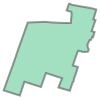

In [57]:
y = col['Geo Shape'][0]
shape = Polygon(y['coords'])
shape

In [58]:
col.sort_values(by=['COLONIA'], ascending=True, inplace = True)
col.head()

,COLONIA,Geo Shape,Transport
346,19 DE MAYO,"{'coords': [(-99.25311772587033, 19.3642842836...",0
11,1RA VICTORIA,"{'coords': [(-99.2041879792452, 19.38585254005...",0
412,1RA VICTORIA SECCION BOSQUES,"{'coords': [(-99.19926610382522, 19.3864621791...",0
138,26 DE JULIO,"{'coords': [(-99.25090819967114, 19.3578506574...",0
322,2DA JALALPA TEPITO (AMPL),"{'coords': [(-99.23037881330154, 19.3805074254...",0


In [78]:
cdf.sort_values(by=['neighborhood'], ascending=True, inplace = True)
cdf.head()

,neighborhood,Speakeasy,Candy Store,Grocery Store,Burger Joint,Martial Arts Dojo,Playground,Coffee Shop,Restaurant,Bar,...,Train Station,Organic Grocery,Kitchen Supply Store,College Theater,Hospital,General College & University,Shoe Repair,Wine Shop,Business Center,Dim Sum Restaurant
0,19 DE MAYO,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1RA VICTORIA,0,0,0,2,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1RA VICTORIA SECCION BOSQUES,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,26 DE JULIO,0,0,0,0,0,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2DA JALALPA TEPITO (AMPL),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
col['Transport'].sum()

1254

In [61]:
col.to_csv('neighborhoods_transport.csv',encoding='utf-8', index=False) #checkpoint for the transport count

In [79]:
cdf.to_csv('cdmx_recommend_venues.csv', encoding='utf-8', index=False) #CheckPoint

# After the previous analysis (shown in the report), the relevant category venues are:
* Bus Stop  / Bus line / Bus Station /Subway**
* Bar/ Club & Nightlife /NightClub Pub Speakeasy  Beer Store/ Count 
* Restaurant/Bistro/count 
* All types of Gym/Fitness venues count
* Art & Entertainment count:  




Lets start by joining the venues 1 by 1 for Restaurants, nightlife, fitness and art & entertainment.
Transport wil be added at the end of this process

In [63]:
cdf = pd.read_csv("cdmx_recommend_venues.csv")
col  = pd.read_csv("neighborhoods_transport.csv")

In [81]:
cdf['Restaurants'] = (cdf['Restaurant']+cdf['Arepa Restaurant']+cdf['Venezuelan Restaurant']+cdf['German Restaurant']+ cdf['Latin American Restaurant']+ cdf['Mediterranean Restaurant']+ cdf['Bistro']+ cdf['Burger Joint']+ cdf['Mexican Restaurant']+cdf['Seafood Restaurant']+cdf['Argentinian Restaurant']+cdf['Japanese Restaurant']+cdf['Brazilian Restaurant']
                    +cdf['Empanada Restaurant']+cdf['Paella Restaurant']+cdf['Lebanese Restaurant']+cdf['Turkish Restaurant']+cdf['Eastern European Restaurant']+cdf['Italian Restaurant']+cdf['Sushi Restaurant']+cdf['Asian Restaurant']
                    +cdf['Fast Food Restaurant']+ cdf['Taco Place']+cdf['Chinese Restaurant']+cdf['American Restaurant'])

cdf.drop(columns = ['Taco Place','Arepa Restaurant','Venezuelan Restaurant', 'German Restaurant','Latin American Restaurant' , 'Mediterranean Restaurant', 'Bistro', 'Burger Joint', 'Mexican Restaurant', 'Seafood Restaurant', 'Argentinian Restaurant', 'Japanese Restaurant', 'Brazilian Restaurant'], inplace = True)
cdf.drop(columns = ['Chinese Restaurant','American Restaurant','Empanada Restaurant', 'Fast Food Restaurant' ,'Paella Restaurant', 'Lebanese Restaurant', 'Turkish Restaurant','Eastern European Restaurant', 'Italian Restaurant', 'Sushi Restaurant', 'Asian Restaurant' ], inplace = True)

                     
cdf.shape

(452, 314)

In [82]:
cdf ['Night Life'] = (cdf['Bar']+cdf['Beer Store']+cdf['Salsa Club']+cdf['Other Nightlife']+cdf['Nightclub']+cdf['Karaoke Bar']+cdf['Jazz Club']
                      +cdf['Beer Bar']+cdf['Comedy Club']+cdf['Speakeasy']+cdf['Wine Bar']+cdf['Wine Bar']+cdf['Casino']+cdf['Sports Bar']
                     )

cdf.drop(columns = ['Bar','Beer Store','Salsa Club','Other Nightlife','Nightclub','Karaoke Bar','Jazz Club','Beer Bar', 'Comedy Club','Speakeasy','Wine Bar', 'Casino','Sports Bar'], inplace = True)
cdf.shape

(452, 302)

In [83]:
cdf['Arts & Entertainment'] = (cdf['History Museum']+cdf['Theater']+cdf['Art Museum']+cdf['Movie Theater']
                               +cdf['Indie Theater']+cdf['Concert Hall']+cdf['Arts & Entertainment']+cdf['Art Gallery']
                              +cdf['Public Art']+cdf['Museum']+ cdf['Historic Site']+cdf['Rock Club'])


cdf.drop(columns = ['History Museum', 'Theater', 'Art Museum', 'Movie Theater', 'Indie Theater', 'Concert Hall', 'Art Gallery','Historic Site', 'Rock Club' ], inplace =True)
cdf.shape

(452, 293)

In [84]:
cdf['Fitness'] = (cdf['Gym']+cdf['Gym / Fitness Center']+cdf['Sports Club']+cdf['Martial Arts Dojo']+cdf['Gymnastics Gym']+cdf['Yoga Studio']+cdf['Soccer Field']+cdf['Boxing Gym']
                 +cdf['Tennis Court']+cdf['Dance Studio']+cdf['Gym Pool']+cdf['Track']+cdf['Baseball Field']+cdf['Rugby Pitch']+cdf['Volleyball Court']+cdf['Park']+cdf['Outdoor Gym']
                 +cdf['Pool']+cdf['Basketball Court'])
#Basketball Court

cdf.drop(columns=['Gym' , 'Outdoor Gym','Gym / Fitness Center','Basketball Court' ,'Sports Club','Pool', 'Martial Arts Dojo','Gymnastics Gym' , 'Yoga Studio', 'Soccer Field', 'Boxing Gym' , 'Tennis Court', 'Dance Studio', 'Gym Pool', 'Track', 'Baseball Field', 'Rugby Pitch','Volleyball Court','Park'], inplace=True)

In [85]:
cdf.head()

,neighborhood,Candy Store,Grocery Store,Playground,Coffee Shop,Restaurant,Pedestrian Plaza,Dessert Shop,Ice Cream Shop,Tea Room,...,College Theater,Hospital,General College & University,Shoe Repair,Wine Shop,Business Center,Dim Sum Restaurant,Restaurants,Night Life,Fitness
0,19 DE MAYO,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
1,1RA VICTORIA,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,16,1,5
2,1RA VICTORIA SECCION BOSQUES,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,0,3
3,26 DE JULIO,0,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2DA JALALPA TEPITO (AMPL),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,2


## Adding the Transport column, obtained by our dataset provided by government. Since both dataset Are ordered ascendingly, we just need to add the column. 

In [86]:
cdf['Transport'] = col['Transport']
cdf.head(20)

,neighborhood,Candy Store,Grocery Store,Playground,Coffee Shop,Restaurant,Pedestrian Plaza,Dessert Shop,Ice Cream Shop,Tea Room,...,Hospital,General College & University,Shoe Repair,Wine Shop,Business Center,Dim Sum Restaurant,Restaurants,Night Life,Fitness,Transport
0,19 DE MAYO,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
1,1RA VICTORIA,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,16,1,5,0
2,1RA VICTORIA SECCION BOSQUES,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,0,3,0
3,26 DE JULIO,0,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2DA JALALPA TEPITO (AMPL),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,2,0
5,2DA EL PIRUL (AMPL),0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,13,0,1,2
6,ABRAHAM GONZALEZ,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,ACACIAS,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,3,0,2,1
8,ACTIPAN,0,0,0,7,1,0,2,1,0,...,0,0,0,0,0,0,16,0,7,11
9,ACUEDUCTO,0,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,2,1,0,0


In [87]:
cdf_classif= cdf[['neighborhood', 'Transport','Restaurants','Arts & Entertainment','Night Life','Fitness']]
cdf_classif.head(25)

,neighborhood,Transport,Restaurants,Arts & Entertainment,Night Life,Fitness
0,19 DE MAYO,0,2,0,0,0
1,1RA VICTORIA,0,16,1,1,5
2,1RA VICTORIA SECCION BOSQUES,0,5,0,0,3
3,26 DE JULIO,0,1,0,0,0
4,2DA JALALPA TEPITO (AMPL),0,2,0,0,2
5,2DA EL PIRUL (AMPL),2,13,0,0,1
6,ABRAHAM GONZALEZ,0,1,0,0,0
7,ACACIAS,1,3,0,0,2
8,ACTIPAN,11,16,1,0,7
9,ACUEDUCTO,0,2,0,1,0


In [88]:
cdf_classif.to_csv('neighbors_venues.csv', encoding='utf-8', index=False) #CheckPoint

# __Recomender__

# We will generate Two tables, one with User Preferences, and another with the main venues of each 

In [2]:


userInput = [
    {'Transport':10.0,'Restaurants':8.0, 'Night Life': 5.0 ,'Arts & Entertainment':5.0,'Fitness':5.0}
]


usrwghts = pd.DataFrame(userInput)

usrwghts

,Transport,Restaurants,Night Life,Arts & Entertainment,Fitness
0,10.0,8.0,5.0,5.0,5.0


In [73]:
cdf_classif = pd.read_csv('neighbors_venues.csv')
cdf_classif.head()

,neighborhood,Transport,Restaurants,Arts & Entertainment,Night Life,Fitness
0,19 DE MAYO,0,2,0,0,0
1,1RA VICTORIA,0,16,1,1,5
2,1RA VICTORIA SECCION BOSQUES,0,5,0,0,3
3,26 DE JULIO,0,1,0,0,0
4,2DA JALALPA TEPITO (AMPL),0,2,0,0,2


In [74]:
cdf_classif['totalWeight'] = (cdf_classif['Transport']*usrwghts['Transport'][0]+
                             cdf_classif['Restaurants']*usrwghts['Restaurants'][0]+
                             cdf_classif['Arts & Entertainment']*usrwghts['Arts & Entertainment'][0]+
                             cdf_classif['Fitness']*usrwghts['Fitness'][0]+
                             cdf_classif['Night Life']*usrwghts['Night Life'][0])

cdf_classif.head()

,neighborhood,Transport,Restaurants,Arts & Entertainment,Night Life,Fitness,totalWeight
0,19 DE MAYO,0,2,0,0,0,16.0
1,1RA VICTORIA,0,16,1,1,5,163.0
2,1RA VICTORIA SECCION BOSQUES,0,5,0,0,3,55.0
3,26 DE JULIO,0,1,0,0,0,8.0
4,2DA JALALPA TEPITO (AMPL),0,2,0,0,2,26.0


In [75]:
cdf_classif.sort_values(by=['Transport'],ascending=False, inplace = True)
#There is an error in the database, since "los Gamitos" has multiple bus stop counts on the same line.
#This was manually reviewed and determined it only has 3 bus stops. 
cdf_classif.drop([256], inplace = True)
cdf_classif.head()

,neighborhood,Transport,Restaurants,Arts & Entertainment,Night Life,Fitness,totalWeight
413,TLACOPAC,29,1,0,0,0,298.0
384,SAN PEDRO DE LOS PINOS,29,8,0,0,4,374.0
288,NARVARTE III,23,13,0,1,1,344.0
396,SANTA URSULA COAPA (PBLO),23,1,0,0,0,238.0
63,CAMPESTRE CHURUBUSCO,21,8,0,0,4,294.0


In [76]:
cdf_classif['total_weight_normalized'] = (cdf_classif['Transport']*usrwghts['Transport'][0] / cdf_classif['Transport'].sum()+
                             cdf_classif['Restaurants']*usrwghts['Restaurants'][0]  / cdf_classif['Restaurants'].sum() +
                             cdf_classif['Arts & Entertainment']*usrwghts['Arts & Entertainment'][0] / cdf_classif['Arts & Entertainment'].sum()  +
                             cdf_classif['Fitness']*usrwghts['Fitness'][0]  / cdf_classif['Fitness'].sum()  +
                             cdf_classif['Night Life']*usrwghts['Night Life'][0]/ cdf_classif['Night Life'].sum()    )

cdf_classif.head()

,neighborhood,Transport,Restaurants,Arts & Entertainment,Night Life,Fitness,totalWeight,total_weight_normalized
413,TLACOPAC,29,1,0,0,0,298.0,0.245718
384,SAN PEDRO DE LOS PINOS,29,8,0,0,4,374.0,0.289120
288,NARVARTE III,23,13,0,1,1,344.0,0.263754
396,SANTA URSULA COAPA (PBLO),23,1,0,0,0,238.0,0.195425
63,CAMPESTRE CHURUBUSCO,21,8,0,0,4,294.0,0.222062


## __Visualization of the Results__

In this section we'll see graphs regarding the best neighborhoods based on several aspects:
* Commuting facilities
* Restaurant count
* Fitness lifestyle
* Arts, culture and Entertainment
* Night Life
* Weighted Average

At the end we'll see a boxplot of the weighted average to see the distribution of our totalWeights. 

### __Commuting facilities__

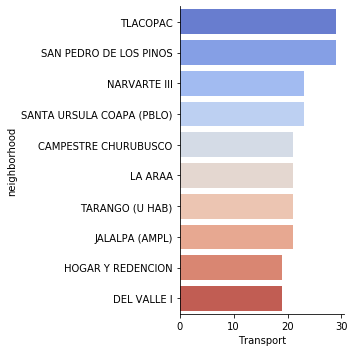

In [118]:
cs = cdf_classif.sort_values(by=['Transport'],ascending=False).head(10)
ax=sns.catplot(x='Transport', y='neighborhood', kind="bar", data = cs, orient = 'h', palette="coolwarm")
plt.show()

### __Restaurant Offer__

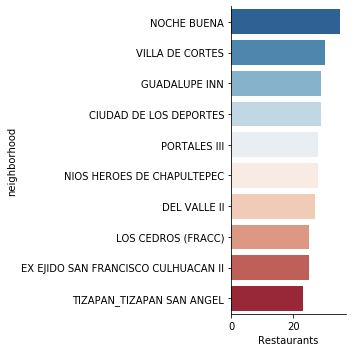

In [119]:
cs = cdf_classif.sort_values(by=['Restaurants'],ascending=False).head(10)
ax=sns.catplot(x='Restaurants', y='neighborhood', kind="bar", data = cs, orient = 'h', palette="RdBu_r")
plt.show()

### __Fitness Lifestyle__

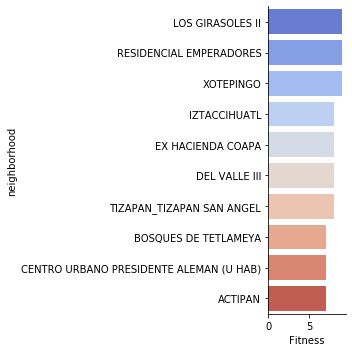

In [129]:
cs = cdf_classif.sort_values(by=['Fitness'],ascending=False).head(10)
ax=sns.catplot(x='Fitness', y='neighborhood', kind="bar", data = cs, orient = 'h', palette="coolwarm")
plt.show()

## __Arts, culture and Entertainment__

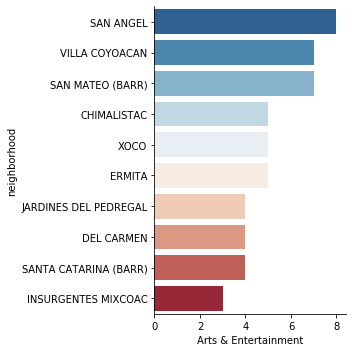

In [121]:
cs = cdf_classif.sort_values(by=['Arts & Entertainment'],ascending=False).head(10)
ax=sns.catplot(x='Arts & Entertainment', y='neighborhood', kind="bar", data = cs, orient = 'h', palette="RdBu_r")
plt.show()

## __Night Life__

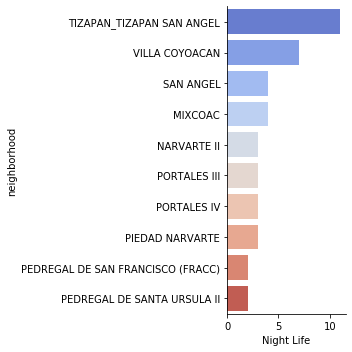

In [130]:
cs = cdf_classif.sort_values(by=['Night Life'],ascending=False).head(10)
ax=sns.catplot(x='Night Life', y='neighborhood', kind="bar", data = cs, orient = 'h', palette="coolwarm")
plt.show()

## __Overall Best Neighborhoods for Millenials in Mexico City__

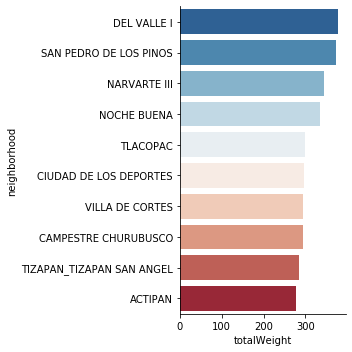

In [7]:
cs = cdf_classif.sort_values(by=['totalWeight'],ascending=False).head(10)
cs
ax=sns.catplot(x='totalWeight', y='neighborhood', kind="bar", data = cs, orient = 'h', palette="RdBu_r")
plt.show()


## __Best Well-rounded Neighborhoods__

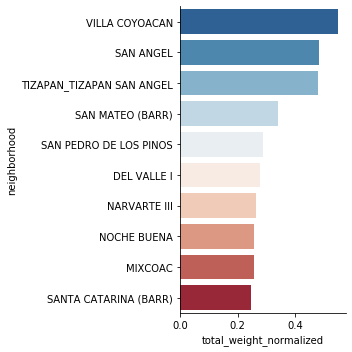

In [8]:
cs = cdf_classif.sort_values(by=['total_weight_normalized'],ascending=False).head(10)

ax=sns.catplot(x='total_weight_normalized', y='neighborhood', kind="bar", data = cs, orient = 'h', palette="RdBu_r")
plt.show()

### __Boxplot to see the distribution :)__

In [126]:
cdf_classif.head()

,neighborhood,Transport,Restaurants,Arts & Entertainment,Night Life,Fitness,totalWeight
413,TLACOPAC,29,1,0,0,0,298.0
384,SAN PEDRO DE LOS PINOS,29,8,0,0,4,374.0
288,NARVARTE III,23,13,0,1,1,344.0
396,SANTA URSULA COAPA (PBLO),23,1,0,0,0,238.0
63,CAMPESTRE CHURUBUSCO,21,8,0,0,4,294.0


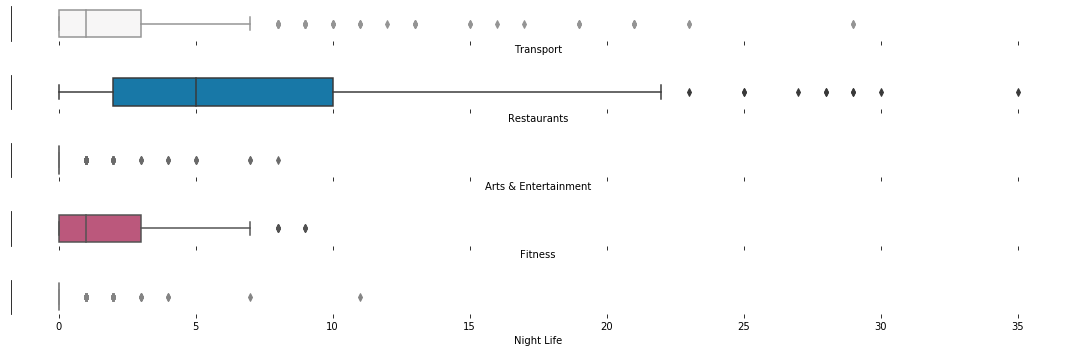

In [165]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(15, 5), sharex=True)

sns.boxplot(x='Transport',data=cdf_classif, ax = ax1,palette ="RdBu_r")

sns.boxplot(x='Restaurants',data=cdf_classif, ax = ax2, palette="winter")


sns.boxplot(x='Arts & Entertainment',data=cdf_classif,ax = ax3, palette="Set3")

sns.boxplot(x='Fitness',data=cdf_classif,ax = ax4, palette="plasma")

sns.boxplot(x='Night Life',data=cdf_classif,ax = ax5, palette="coolwarm")
# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

## Clustering

Additional to this information, lets cluster each city based on the principal venues

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [77]:
cdf_classif.head()

,neighborhood,Transport,Restaurants,Arts & Entertainment,Night Life,Fitness,totalWeight,total_weight_normalized
413,TLACOPAC,29,1,0,0,0,298.0,0.245718
384,SAN PEDRO DE LOS PINOS,29,8,0,0,4,374.0,0.289120
288,NARVARTE III,23,13,0,1,1,344.0,0.263754
396,SANTA URSULA COAPA (PBLO),23,1,0,0,0,238.0,0.195425
63,CAMPESTRE CHURUBUSCO,21,8,0,0,4,294.0,0.222062


In [78]:
# set number of clusters
kclusters = 4

cdmx_grouped_clustering = cdf_classif.drop(columns=['totalWeight','neighborhood','total_weight_normalized'])
cdmx_grouped_clustering.head()
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cdmx_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 0, 3, 1, 3, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 2, 1, 2, 2, 0, 2,
       2, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 2, 0, 0, 0, 2, 1, 2, 1, 1, 2, 1,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 2, 1, 0, 2, 0, 2, 0, 2, 1,
       1, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 1, 1, 1, 1, 2, 2, 0, 0,
       0, 1, 2, 2, 2, 1, 2, 0, 2, 0, 1, 2, 1, 0, 1, 0, 2, 0, 2, 1, 2, 2,
       2, 1, 2, 2, 2, 0, 2, 1, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 2,
       1, 2, 0, 0, 0, 0, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0,
       1, 1, 0, 0, 2, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2,
       0, 1, 2, 0, 2, 1, 0, 0, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 1, 2, 2,
       0, 2, 2, 0, 1, 2, 0, 2, 1, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 1, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2,
       0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1,

In [79]:
cdf_classif['label'] = kmeans.labels_
cdf_classif.head()

,neighborhood,Transport,Restaurants,Arts & Entertainment,Night Life,Fitness,totalWeight,total_weight_normalized,label
413,TLACOPAC,29,1,0,0,0,298.0,0.245718,3
384,SAN PEDRO DE LOS PINOS,29,8,0,0,4,374.0,0.289120,3
288,NARVARTE III,23,13,0,1,1,344.0,0.263754,3
396,SANTA URSULA COAPA (PBLO),23,1,0,0,0,238.0,0.195425,3
63,CAMPESTRE CHURUBUSCO,21,8,0,0,4,294.0,0.222062,3


In [80]:
cdf_classif['Latitude'] = 0.0
cdf_classif['Longitude'] = 0.0
for rowcol, rownamecol in dfcol.iterrows():
    for rowcdf, rwnm in cdf_classif.iterrows():
        if(rwnm['neighborhood'] == rownamecol['COLONIA']):
            cdf_classif['Latitude'][rowcdf] = dfcol['lat'][rowcol]
            cdf_classif['Longitude'][rowcdf] = dfcol['long'][rowcol]
            
cdf_classif.head()

C:\Users\alecb\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\alecb\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,neighborhood,Transport,Restaurants,Arts & Entertainment,Night Life,Fitness,totalWeight,total_weight_normalized,label,Latitude,Longitude
413,TLACOPAC,29,1,0,0,0,298.0,0.245718,3,19.354855,-99.194174
384,SAN PEDRO DE LOS PINOS,29,8,0,0,4,374.0,0.289120,3,19.388862,-99.191699
288,NARVARTE III,23,13,0,1,1,344.0,0.263754,3,19.392020,-99.158844
396,SANTA URSULA COAPA (PBLO),23,1,0,0,0,238.0,0.195425,3,19.309695,-99.144395
63,CAMPESTRE CHURUBUSCO,21,8,0,0,4,294.0,0.222062,3,19.345409,-99.135866


In [81]:
# create map
latitude = 19.4284700 
longitude= -99.1276600
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, tiles='cartodbpositron')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cdf_classif['Latitude'], cdf_classif['Longitude'], cdf_classif['neighborhood'], cdf_classif['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [88]:
#Transport cluster = 3  yellow
#Restaurant cluster = 1 purple
# fitness = 0 red
#Arts & Entertainment = 2 light blue


cdf_classif.head(15)

,neighborhood,Transport,Restaurants,Arts & Entertainment,Night Life,Fitness,totalWeight,total_weight_normalized,label,Latitude,Longitude
413,TLACOPAC,29,1,0,0,0,298.0,0.245718,3,19.354855,-99.194174
384,SAN PEDRO DE LOS PINOS,29,8,0,0,4,374.0,0.289120,3,19.388862,-99.191699
288,NARVARTE III,23,13,0,1,1,344.0,0.263754,3,19.392020,-99.158844
396,SANTA URSULA COAPA (PBLO),23,1,0,0,0,238.0,0.195425,3,19.309695,-99.144395
63,CAMPESTRE CHURUBUSCO,21,8,0,0,4,294.0,0.222062,3,19.345409,-99.135866
195,LA ARAA,21,1,0,0,1,223.0,0.184902,3,19.363546,-99.240317
401,TARANGO (U HAB),21,3,0,0,1,239.0,0.190169,3,19.360804,-99.223912
185,JALALPA (AMPL),21,1,0,0,2,228.0,0.191145,3,19.377869,-99.233139
110,DEL VALLE I,19,19,0,1,6,377.0,0.277236,3,19.397920,-99.165362
280,MOLINO DE ROSAS (AMPL),19,3,0,0,0,214.0,0.167162,3,19.369904,-99.201522


### Thank you for reading all the way down here!

Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r